# Cluster Landsat 7 3-year TOA percentile composites

In this notebook we show how to cluster Landsat 7 data downloaded from Google Earth Engine (https://explorer.earthengine.google.com/#detail/LANDSAT%2FLE7_TOA_3YEAR).

In [1]:
%matplotlib inline
import sys, os, time
from collections import defaultdict

import numpy as np

import rasterio

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans

In [2]:
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

## Load and display data

In [3]:
%%time

f = rasterio.open("data/LE7_TOA_3YEAR_2000_2002.tif", "r")
tile = f.read()
# the GeoTIFFs downloaded from GEE are loaded in a channel first format
tile = np.rollaxis(tile, 0, 3) # convert to channel last format
f.close()

CPU times: user 784 ms, sys: 48 ms, total: 832 ms
Wall time: 834 ms


In [4]:
nodata_mask = ~((tile == 0).sum(axis=2) == 0) # every pixel that has all 0 values should be counted as NoData

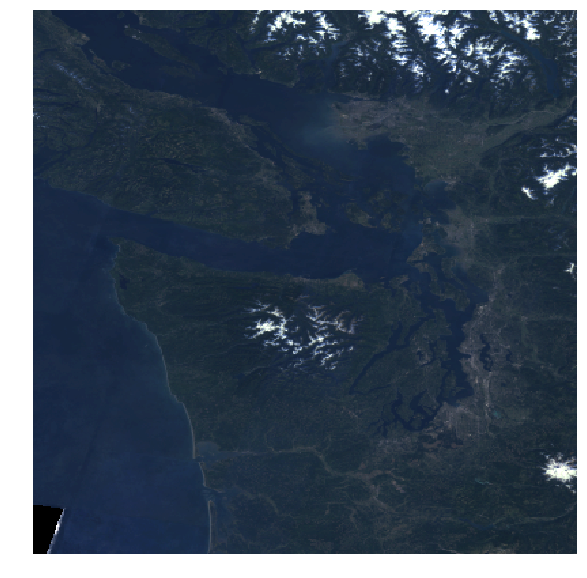

In [5]:
# show the RGB channels of the 400x400 patch in the upper left corner
image = tile[:400,:400, [2,1,0]]
normalization = 100.0 # the Landsat 7 values will be in [0,255], we adjust this to change the general brightness of the resulting image

plt.figure(figsize=(10,10))
plt.imshow((image / normalization).clip(0,1)) # dividing by 100.0 (normalization) doesn't garuntee all pixels will be in [0,1] so we clip too
plt.axis("off")
plt.show()
plt.close()

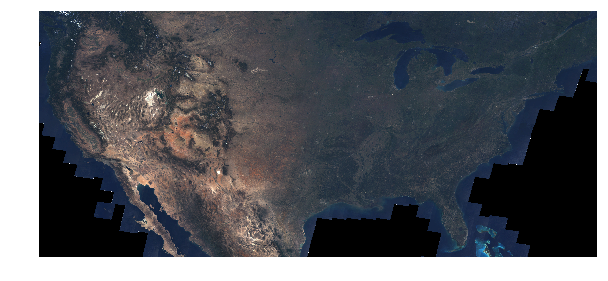

In [6]:
# display RGB for all data
image = tile[:,:, [2,1,0]]
normalization = 100.0

plt.figure(figsize=(10,10))
plt.imshow((image / normalization).clip(0,1))
plt.axis("off")
plt.show()
plt.close()

## Sample random points

In [7]:
num_patches = 750000
print("Percentage of data to sample: %0.4f" % ((float(num_patches) / (tile.shape[0] * tile.shape[1])) * 100.0))

Percentage of data to sample: 3.9753


In [8]:
%%time

patches = np.zeros((num_patches, 7), dtype=float)
patch_coordinates = np.zeros((num_patches, 2), dtype=int)

i = 0
while i < num_patches:
    
    # choose a random coordinate
    j = np.random.randint(0, tile.shape[0])
    k = np.random.randint(0, tile.shape[1])
    
    if nodata_mask[j,k]: # if we chose a nodata value then reject this coordinate
        pass
    else:
        patches[i] = tile[j,k,:].astype(float)
        patch_coordinates[i] = [j,k]
        i += 1

CPU times: user 3.67 s, sys: 16 ms, total: 3.68 s
Wall time: 3.68 s


## "Train" KMeans model

In [9]:
num_clusters = 5

In [10]:
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters,
    init="k-means++",
    max_iter=100,
    batch_size=1000,
    verbose=0,
    compute_labels=True,
    random_state=None,
    tol=0.0,
    max_no_improvement=20,
    init_size=None,
    n_init=3,
    reassignment_ratio=0.01
)

In [11]:
kmeans.fit(patches)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=20, n_clusters=5,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [12]:
# show the class distribution of our "training" set

labels = kmeans.predict(patches)
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int32), array([173196, 171651, 126141,  68443, 210569]))


## Apply model to all of LE7_TOA_3YEAR_2000_2002 

In [13]:
all_patches = tile.reshape(-1, 7)

In [14]:
%%time
label_grid_2000 = kmeans.predict(all_patches)
label_grid_2000 = label_grid_2000.reshape(tile.shape[0], tile.shape[1])

CPU times: user 8.39 s, sys: 452 ms, total: 8.84 s
Wall time: 8.84 s


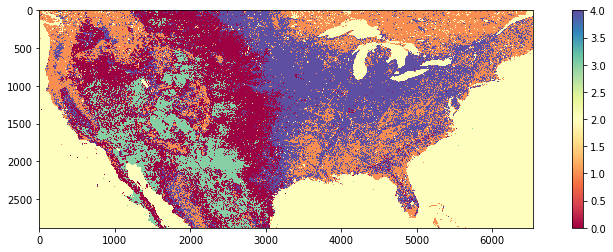

In [15]:
# map showing raw label predictions
plt.figure(figsize=(14,4))
plt.imshow(label_grid_2000, cmap="Spectral")
plt.colorbar()
plt.show()
plt.close()

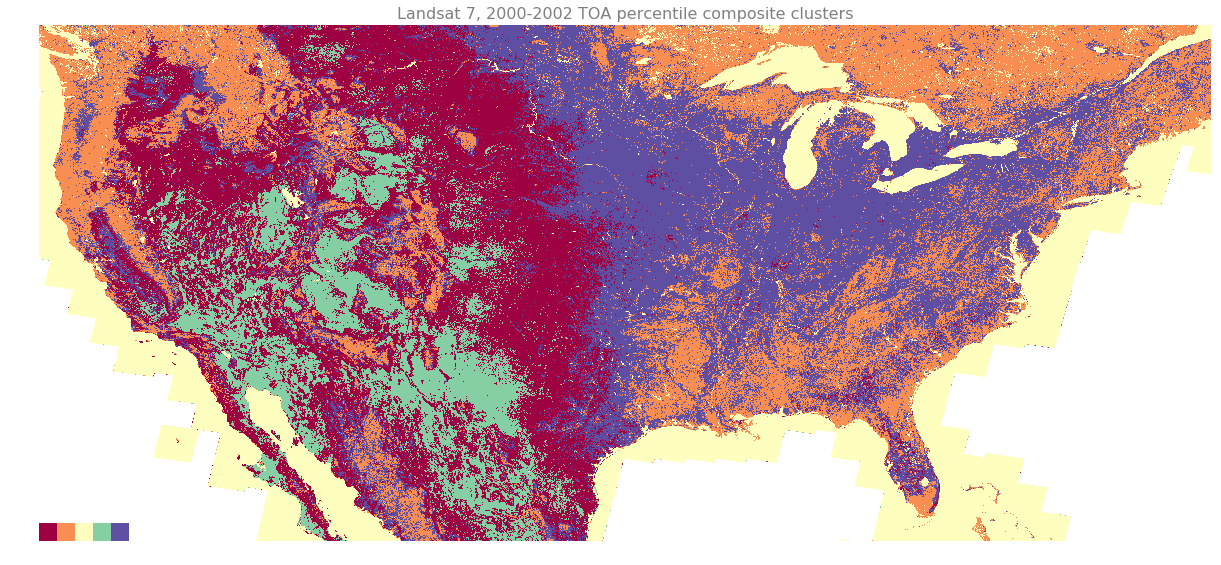

In [16]:
# display a nicer map that removes nodata pixels and draws the class colors in bottom left corner
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0, vmax=num_clusters-1)

grid = np.zeros((tile.shape[0], tile.shape[1], 4), dtype=float)

for i in range(num_clusters):
    color = cmap(norm(i))
    grid[label_grid_2000==i,:] = color
    
grid[nodata_mask] = 1.0
for i in range(num_clusters):
    color = cmap(norm(i))    
    grid[-100:, i*100:(i+1)*100, :] = color

fig, ax = plt.subplots(1,1,figsize=(21,14))

plt.imshow(grid)

plt.title("Landsat 7, 2000-2002 TOA percentile composite clusters", fontsize=16, color="gray")
plt.axis("off")
plt.show()
plt.close()

## Apply KMeans model to 2010-2012 data

In [17]:
%%time

f = rasterio.open("data/LE7_TOA_3YEAR_2010_2012.tif", "r")
tile = f.read()
tile = np.rollaxis(tile, 0, 3)
f.close()

CPU times: user 680 ms, sys: 40 ms, total: 720 ms
Wall time: 717 ms


In [18]:
all_patches = tile.reshape(-1, 7)
label_grid_2010 = kmeans.predict(all_patches)
label_grid_2010 = label_grid_2010.reshape(tile.shape[0], tile.shape[1])

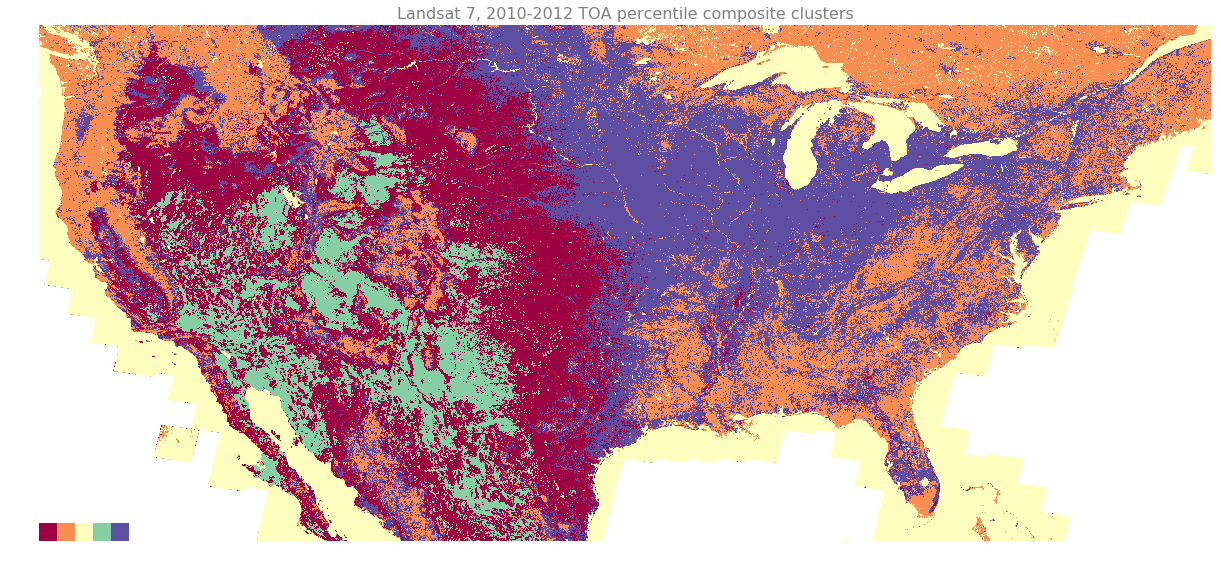

In [19]:
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0, vmax=num_clusters-1)

grid = np.zeros((tile.shape[0], tile.shape[1], 4), dtype=float)

for i in range(num_clusters):
    color = cmap(norm(i))
    grid[label_grid_2010==i,:] = color
    
grid[nodata_mask] = 1.0
for i in range(num_clusters):
    color = cmap(norm(i))    
    grid[-100:, i*100:(i+1)*100, :] = color

fig, ax = plt.subplots(1,1,figsize=(21,14))

plt.imshow(grid)

plt.title("Landsat 7, 2010-2012 TOA percentile composite clusters", fontsize=16, color="gray")
plt.axis("off")
plt.show()
plt.close()